In [1]:
from copy import copy

from typing import Dict, Any

import ogb.utils.features
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import rdkit
import torch
import torch.nn.functional as F
import torch_geometric as pyg
import wandb

from torch import Tensor
from torch.nn import Sequential, Linear, ReLU, Module
from torch.optim import Optimizer, Adam

from torch_geometric.loader import DataLoader

from torchmetrics.functional import auc
from torchmetrics import Metric, Accuracy, Precision, Recall, F1Score, AUROC, PrecisionRecallCurve

from IPython.display import display


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def add_key_prefix(prefix, dict: Dict) -> Dict:
    return {f"{prefix}{key}": val for key, val in dict.items()}    

In [4]:
def fix_off_by_one_in_open_graph_benchmark():
    """
    There is an off by one error in one digit in the open graph benchmark.
    This affects pytorch geometric AtomEncoder layer.
    If I have still energy after this task, I will report an issue on github.

    If the fix works, this print should show at the end of this cell
    """
    print("OGB off by one hijacked!")
    return [119, 4, 12, 12, 10, 6, 7, 2, 2]

ogb.utils.features.get_atom_feature_dims = fix_off_by_one_in_open_graph_benchmark

import ogb.graphproppred.mol_encoder

OGB off by one hijacked!


## Data loading

In [5]:
def transform_lipo(sample: pyg.data.Data) -> pyg.data.Data:
    sample = copy(sample)
    sample.y = (sample.y > 3.5).float().squeeze()
    return sample

def transform_hiv(sample: pyg.data.Data) -> pyg.data.Data:
    sample = copy(sample)
    sample.y = sample.y.squeeze()
    return sample

def transform_bppp(sample: pyg.data.Data) -> pyg.data.Data:
    sample = copy(sample)
    sample.y = sample.y.squeeze()
    return sample

def transform_tox21(sample: pyg.data.Data) -> pyg.data.Data:
    sample = copy(sample)
    sample.y = sample.y.squeeze()[2]
    return sample

def transform_clintox(sample: pyg.data.Data) -> pyg.data.Data:
    sample = copy(sample)
    sample.y = sample.y.squeeze()[0]
    return sample

def is_y_not_na(sample: pyg.data.Data) -> bool:
    return not torch.isnan(sample.y)


transforms = {
    "lipo": transform_lipo,
    "hiv": transform_hiv,
    "bbbp": transform_bppp,
    "clintox": transform_clintox,
    "tox21": transform_tox21,
}

datasets = {}

for name, transform in transforms.items():
    print("preparing:", name, end=" ")
    data = pyg.datasets.MoleculeNet("./data/", name)
    data = map(transform, data)
    data = filter(is_y_not_na, data)
    data = pd.Series(data)
    datasets[name] = data

    for i in range(100):
        sample = data[i]
        assert sample.y.shape == tuple()
        assert sample.y.dtype == torch.float32
        assert any([
            torch.isclose(sample.y, torch.tensor(0.0)),
            torch.isclose(sample.y, torch.tensor(1.0))
        ])
    
    print(len(data))

del data

preparing: lipo 4200
preparing: hiv 41127
preparing: bbbp 2039
preparing: clintox 1478
preparing: tox21 6549


In [6]:
print(datasets["hiv"][i])

Data(x=[10, 9], edge_index=[2, 20], edge_attr=[20, 3], y=0.0, smiles='O=C(O)c1ccccc1S')


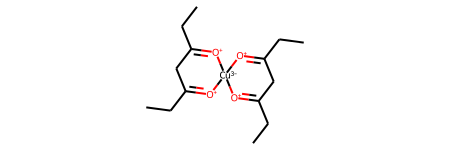

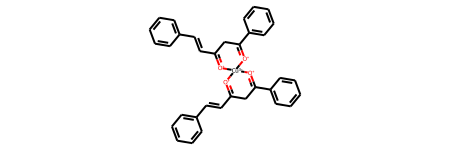

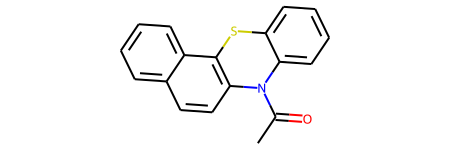

In [7]:
for i in range(3):
    display(rdkit.Chem.MolFromSmiles(datasets["hiv"][i].smiles))

# Model architecture

In [8]:
class MyGAT(Module):
    def __init__(self, edge_dim, hidden_channels, num_heads, num_layers):

        super().__init__()

        self.atom_embedding = ogb.graphproppred.mol_encoder.AtomEncoder(hidden_channels)
        self.bond_embedding = ogb.graphproppred.mol_encoder.BondEncoder(edge_dim)

        self.gat = pyg.nn.models.GAT(
            hidden_channels,
            hidden_channels,
            num_layers,
            heads=num_heads,
            edge_dim=edge_dim,
            act=torch.relu,
            norm=pyg.nn.GraphNorm(hidden_channels),
            jk="last",
        )
    
        glob_att_gate = Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            ReLU(),
            Linear(hidden_channels // 2, 1),
        )

        self.glob_pooling = pyg.nn.glob.GlobalAttention(gate_nn=glob_att_gate)

        self.out = Linear(hidden_channels, 1)

    def forward(
        self,
        node_features: Tensor,
        edge_index: Tensor,
        edge_features: Tensor,
        batch_index: Tensor,
    ) -> Tensor:

        # batches are done by creating one big graph from many graphs (now components)
        # message passing only occurs inside the components, which is ok, but
        # global pooling needs to know which parts of the big graph are different samples
        # this is why there is batch_index tensor

        #with open("foo.txt", "a") as file:
        #    file.write(f"{node_features.shape} {node_features.min(dim=)[0].cpu().numpy()}, {node_features.max(dim=-1)[0].cpu().numpy()}\n")

    
        node_features = self.atom_embedding(node_features)
        edge_features = self.bond_embedding(edge_features)

        x = self.gat(node_features, edge_index, edge_features)
        x = self.glob_pooling(x, batch_index)
        y = self.out(x)
        return y.squeeze()
        

Just a sidenote. AtomEncoder and BondEncoder serve as an embedding layer. The features precomputed in pytorch geometric MoleculeNet are integers (atomic number, and so on) and in my opinion (and in opinion of people behing Open Graph Benchmak) should be treated as categorical values (thus the embedding layer). However, I experimented with both options - use embedding or not use it and just feed the unprocessed (and unnormalized!) integers into the network and have found out that the quality of the network is basically the same.

I have some hypothesis why this is so. First is that embedding the bonds does not help because the type of bond is not important and important is just the presence or absence of the bond (edge). The second hypothesis is that embedding the node features does not help because most of the atoms are oxygen and carbon anyways, and if there are just a few different elements, it is not that difficult for the network to distinguish them. Third hypothesis is that even if every element is different and could be treated as category, the atomic number is still a number of particles in the nucleus, so it is in this sense an ordinal value and the number of particles in nuclei is a relevant information for predicting chemical properties.

Unfortunately, I don't posses enough chemical knowledge to adequately reason about these hypotheses, so I guess it will remain a mystery.

In [9]:
class AUPRC(Metric):
    """
    Simple implementation of torchmetric for area under precision-recall curve
    """
    
    def __init__(self, **kwargs):
        super().__init__()
        self.curve = PrecisionRecallCurve(**kwargs)

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        self.curve.update(preds, target)
    
    def reset(self):
        self.curve.reset()

    def compute(self):
        precisions, recalls, _ = self.curve.compute()
        return auc(recalls, precisions)


## Lightning module

Because writing training loop from scratch is tedious

In [10]:
class GNNClassification(pl.LightningModule):
    def __init__(
        self,
        pos_weight: float,
        lr: float,
        num_edge_features: int,
        num_attention_heads: int,
        hidden_dim: int,
        num_layers: int,
        val_loader_names: str,
        decision_threshold_for_metrics: float
    ):
        super().__init__()
        self.save_hyperparameters()
        
        self.pos_weight = pos_weight
        self.lr = lr
        self.val_loader_names = val_loader_names
        self.decision_threshold_for_metrics = decision_threshold_for_metrics
        
        self.gnn = MyGAT(
            edge_dim=num_edge_features,
            hidden_channels=hidden_dim,
            num_heads=num_attention_heads,
            num_layers=num_layers,
        )

        self.metrics = {
            name: self.get_metrics(decision_threshold_for_metrics) for name in self.val_loader_names.values()
        }

        self.base_loss = F.binary_cross_entropy_with_logits

    def get_metrics(self, t: float) -> Dict[str, Metric]:
        return {
            "accuracy": Accuracy(threshold=t),
            "recall": Recall(threshold=t),
            "precision": Precision(threshold=t),
            "f1": F1Score(threshold=t),
            "roc_auc": AUROC(),
            "pr_auc": AUPRC(),
        }

    def configure_optimizers(self) -> Optimizer:
        return Adam(self.gnn.parameters(), lr=self.lr)

    def loss_fn(self, logits: Tensor, target: Tensor) -> Tensor:
        not_missing = ~target.isnan()
        return self.base_loss(
            logits[not_missing],
            target[not_missing],
            pos_weight=self.pos_weight * torch.ones_like(target[not_missing]),
        )

    def forward(self, batch) -> Tensor:
        inputs = batch.x, batch.edge_index, batch.edge_attr, batch.batch
        logits = self.gnn(*inputs)
        return torch.sigmoid(logits)

    def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
        return self.forward(batch)

    def training_step(self, batch, batch_idx) -> Tensor:
        inputs = batch.x, batch.edge_index, batch.edge_attr, batch.batch
        logits = self.gnn(*inputs)
        loss = self.loss_fn(logits, batch.y)
        self.log("loss_train", loss, batch_size=batch.y.shape[0])
        return loss

    def validation_step(self, batch, batch_idx, loader_idx) -> Tensor:
        loader_name = self.val_loader_names[loader_idx]
        batch_size = batch.y.shape[0]
        inputs = batch.x, batch.edge_index, batch.edge_attr, batch.batch
        
        logits = self.gnn(*inputs)
        loss = self.loss_fn(logits, batch.y)
        self.log(f"loss/{loader_name}", loss, batch_size=batch_size, add_dataloader_idx=False)

        pred_probs = torch.sigmoid(logits).flatten()
        true = batch.y.flatten()
        knowns = ~true.isnan()

        for metric in self.metrics[loader_name].values():
            metric.update(pred_probs[knowns].cpu(), true[knowns].int().cpu())

        return loss

    def validation_epoch_end(self, outputs) -> None:
        for loader_name, metrics in self.metrics.items():
            for name, metric in metrics.items():
                self.log(f"{name}/{loader_name}", metric.compute(), add_dataloader_idx=False)
                metric.reset()


## Data preparation

Nothing special, GNNs operate directly on graphs, so there is not much to do.

In [11]:
def split_data(data):
    train_split = np.random.default_rng(seed=0).uniform(0, 1, size=len(data))

    indeces_train = np.where((train_split < 0.8))[0]
    indeces_valid = np.where((train_split < 0.9) & (train_split >= 0.8))[0]
    indeces_tests = np.where((train_split > 0.9))[0]

    indeces_train_mini = np.random.default_rng(42).choice(indeces_train, len(indeces_tests))

    assert set.intersection(set(indeces_train), set(indeces_valid)) == set()
    assert set.intersection(set(indeces_train), set(indeces_tests)) == set()
    assert set.intersection(set(indeces_valid), set(indeces_tests)) == set()

    ds_train = data[indeces_train].tolist()
    ds_valid = data[indeces_valid].tolist()
    ds_tests = data[indeces_tests].tolist()
    ds_train_mini = data[indeces_train_mini].tolist()

    pos_frac = data[indeces_train].apply(lambda sample: sample.y.item()).mean()
    print(f"proportion of positive samples: {pos_frac:.3f}")
    print(f"weight that will be given to positive samples in loss: {1/pos_frac:.3f}")

    return ds_train, ds_valid, ds_tests, ds_train_mini, pos_frac


In [12]:
ds_train, ds_valid, ds_tests, ds_train_mini, pos_frac = split_data(datasets["hiv"])


proportion of positive samples: 0.035
weight that will be given to positive samples in loss: 28.393


# Hyperparameters

I use multihead attention. But the hidden_dim is for all attention heads together, not per one head.

In [13]:
hyperparams_all = [
    dict(hidden_dim=100, num_layers=4,  num_attention_heads=2),

    dict(hidden_dim=200, num_layers=5,  num_attention_heads=4),
    dict(hidden_dim=200, num_layers=10, num_attention_heads=8),

    dict(hidden_dim=256, num_layers=12, num_attention_heads=8),
]


for hyperparams in hyperparams_all:
    c = GNNClassification(
        pos_weight=1,
        lr=0.0001,
        **hyperparams,
        num_edge_features=20,
        val_loader_names={},
        decision_threshold_for_metrics=0.5,
    )
    print(hyperparams, sum(p.numel() for p in c.parameters() if p.requires_grad), "params")
    del c

{'hidden_dim': 100, 'num_layers': 4, 'num_attention_heads': 2} 83762 params
{'hidden_dim': 200, 'num_layers': 5, 'num_attention_heads': 4} 322662 params
{'hidden_dim': 200, 'num_layers': 10, 'num_attention_heads': 8} 549662 params
{'hidden_dim': 256, 'num_layers': 12, 'num_attention_heads': 8} 1013254 params


## Configs

This is done so that everything can be logged into weights and biases easily

In [14]:
def get_configs(hyperparams: Dict[str, Any]) -> Dict[str, Dict[str, Any]]:
    loader_config = dict(
        batch_size=128,
        num_workers=6,
    )

    classification_config = dict(
        pos_weight=1/pos_frac,
        lr=0.0001,
        **hyperparams,
        num_edge_features=20,
        decision_threshold_for_metrics=0.5,
    )

    early_stop_config = dict(
        monitor="pr_auc/valid",
        mode="max",
        patience=8,
        min_delta=0.02,
    )

    checkpoint_config = dict(
        dirpath=model_dir,
        save_top_k=3,
        monitor="pr_auc/valid",
        mode="max",
    )

    trainer_config = dict(
        min_epochs=10,
        max_epochs=100,
        log_every_n_steps=20,
        accelerator="gpu" if device == "cuda" else None,
    )

    return {
        "loader": loader_config,
        "classification": classification_config,
        "early_stopping": early_stop_config,
        "checkpointing": checkpoint_config,
        "trainer": trainer_config,
    }


## Boilerplate for evaluation

In [15]:
def evaluate(
    classificator: GNNClassification,
    loaders: Dict[str, DataLoader],
) -> Dict[str, Dict[str, float]]:

    results = {}

    with torch.no_grad():
        for name, loader in loaders.items():
            metrics = classificator.get_metrics(t=0.5)
            for metric in metrics.values():
                metric.reset()

            for batch in loader:
                batch = batch.to(classificator.device)
                logits = classificator(batch).flatten().cpu()
                pred = torch.sigmoid(logits)
                y = batch.y.int().flatten().cpu()
                for metric in metrics.values():
                    metric.update(pred, y)
            
            results[name] = {name: metric.compute().item() for name, metric in metrics.items()}

    return results

# Training

The output is huge. Instead, I recommend you to look at the weights and biases:
https://wandb.ai/markcheeky/molecules/table?workspace=user-markcheeky

Everything is logged there from hyperparameters and metrics during training to final evaluation on test set.

There are 2 main sets of runs. In one, all runs have "with_embedding" tag. They correspond to this execution of the notebook I'm submitting.
The second set of runs is without that tag and correspond to the experiment where I did not use the embedding layer for atom and bond features and just feeded the integers into the network directly.

After this endless cell output, there is also final evaluation.

In [16]:
import logging

search_results = []

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

for dataset_name, dataset in datasets.items():
    
    print("-"*50)
    print(dataset_name.upper().center(50))
    print("-"*50)

    for hyperparams in hyperparams_all:

        wandb_logger = pl.loggers.WandbLogger(
            project="molecules",
            tags=[dataset_name, "with_embeddings"]
        )
            
        model_dir = f"./models/gnn_{wandb.run.name}"
        wandb.config.dataset_name = dataset_name

        ds_train, ds_valid, ds_tests, ds_train_mini, pos_frac = split_data(dataset)
        configs = get_configs(hyperparams)

        for config_name, config in configs.items():
            if config_name == "classification":
                # these get logged automatically
                continue
            wandb.config.update(add_key_prefix(config_name + "_", config))

        loader_train = DataLoader(ds_train, **configs["loader"], shuffle=True)
        loader_valid = DataLoader(ds_valid, **configs["loader"])
        loader_tests = DataLoader(ds_tests, **configs["loader"])
        loader_train_mini = DataLoader(ds_train_mini, **configs["loader"])

        valid_loaders = {"valid": loader_valid, "train_mini": loader_train_mini}
        tests_loaders = {"train_mini": loader_train_mini, "valid": loader_valid, "tests": loader_tests}
        
        gnn_classification = GNNClassification(
            **configs["classification"],
            val_loader_names=dict(enumerate(valid_loaders.keys())),
        )

        early_stop = pl.callbacks.EarlyStopping(**configs["early_stopping"])
        checkpointing = pl.callbacks.ModelCheckpoint(**configs["checkpointing"])

        trainer = pl.Trainer(
            default_root_dir=model_dir,
            **configs["trainer"],
            enable_progress_bar=False,
            enable_model_summary=False,
            callbacks=[early_stop, checkpointing],
            logger=wandb_logger,
        )

        trainer.fit(
            gnn_classification,
            train_dataloaders=loader_train,
            val_dataloaders=list(valid_loaders.values()),
        )

        gnn_classification = GNNClassification.load_from_checkpoint(checkpointing.best_model_path).eval()

        results = pd.DataFrame(evaluate(gnn_classification, tests_loaders))

        search_results.append({
            "dataset": dataset_name,
            "wandb_run": wandb.run.name,
            "hyperparams": hyperparams,
            "model_dir": model_dir,
            "best_model_path": checkpointing.best_model_path,
            "results": results,
        })

        print(dataset_name, model_dir, hyperparams)
        display(results.round(2))

        wandb.log({
            "final_metrics": wandb.Table(dataframe=results)
        })

        wandb.finish()

            

--------------------------------------------------
                       LIPO                       
--------------------------------------------------


wandb: Currently logged in as: markcheeky (use `wandb login --relogin` to force relogin)


proportion of positive samples: 0.120
weight that will be given to positive samples in loss: 8.314


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


lipo ./models/gnn_devout-waterfall-121 {'hidden_dim': 100, 'num_layers': 4, 'num_attention_heads': 2}


,train_mini,valid,tests
accuracy,0.11,0.13,0.12
recall,1.00,1.00,1.00
precision,0.11,0.13,0.12
f1,0.20,0.23,0.21
roc_auc,0.93,0.85,0.82
pr_auc,0.54,0.42,0.36


accuracy/train_mini,▁▃▅▅▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇███
accuracy/valid,▁▃▅▅▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇██▇▇██▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
f1/train_mini,▁▂▃▃▅▄▄▅▅▅▅▅▆▅▆▆▆▆▆▇▇▇▆▆▇█▇█▇███
f1/valid,▁▂▄▄▄▄▅▅▅▅▆▅▅▅▆▆▆▅▆▇▇▇▇▇██▇▇▇█▇█
loss/train_mini,██▇▆▅▅▅▄▄▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁
loss/valid,██▇▆▅▄▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂
loss_train,██▆▅▆▅▄▅▆▇▅▅▄▅▅▃▃▃▄▅▃▃▄▂▄▁▃▃▃▃▂▄▃▃▃▂▃▃▂▄
pr_auc/train_mini,▁▂▂▃▄▄▅▅▆▆▆▆▆▆▆▆▇▆▇▆▇▇▇▇▇▇██████
pr_auc/valid,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇█▇█▇▇▇▇█▇▇▇
precision/train_mini,▁▂▃▃▄▄▄▄▄▅▅▅▅▄▆▆▅▅▅▇▇▇▅▆▇▇▆█▇██▇


proportion of positive samples: 0.120
weight that will be given to positive samples in loss: 8.314


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


lipo ./models/gnn_quiet-wood-122 {'hidden_dim': 200, 'num_layers': 5, 'num_attention_heads': 4}


,train_mini,valid,tests
accuracy,0.11,0.13,0.12
recall,1.00,1.00,1.00
precision,0.11,0.13,0.12
f1,0.20,0.23,0.21
roc_auc,0.95,0.86,0.85
pr_auc,0.66,0.44,0.39


accuracy/train_mini,▁▅▅▅▄▆▅▅▅▅▆▆▆▇▆▆▆▇▆▇▇███
accuracy/valid,▁▅▅▅▅▆▅▆▅▅▆▆▇▇▆▇▆█▆▇▇██▇
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
f1/train_mini,▁▃▄▄▃▄▄▄▄▄▅▅▆▆▅▅▅▇▅▇▇█▇█
f1/valid,▁▃▃▃▄▄▄▅▄▄▆▆▆▆▅▇▅█▆▆▇█▇▇
loss/train_mini,█▇▅▅▅▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▁▂▁
loss/valid,█▆▄▄▂▂▂▂▃▂▂▁▃▁▂▁▂▂▂▃▃▅▅▄
loss_train,█▆▅▆▅▆▄▆▅▄▄▄▅▄▃▃▆▂▄▃▄▁▄▃▃▃▁▂▂▃▂▂
pr_auc/train_mini,▁▃▃▃▄▃▄▅▄▄▅▆▆▅▆▇▆▇▆▇▇▇██
pr_auc/valid,▁▂▃▃▅▅▅▅▆▅▆▇▇▇▆█▆█▆▇█▇▇▇
precision/train_mini,▁▃▃▄▃▄▃▄▄▄▅▅▅▅▅▅▅▆▅▇▇█▇█


proportion of positive samples: 0.120
weight that will be given to positive samples in loss: 8.314


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


lipo ./models/gnn_vivid-plasma-123 {'hidden_dim': 200, 'num_layers': 10, 'num_attention_heads': 8}


,train_mini,valid,tests
accuracy,0.11,0.13,0.12
recall,1.00,1.00,1.00
precision,0.11,0.13,0.12
f1,0.20,0.23,0.21
roc_auc,0.97,0.86,0.84
pr_auc,0.69,0.48,0.36


accuracy/train_mini,▁▃▄▄▄▅▆▆▆▅▇▇▆▇▆▇▇▇▇█▇
accuracy/valid,▁▃▅▄▄▅▆▆▆▆▇▇▇▇▆▇██▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
f1/train_mini,▁▂▃▃▃▄▄▄▅▄▅▅▅▆▅▆▆▆▇█▇
f1/valid,▁▃▅▄▄▅▆▆▅▆▇▄█▇▆▇██▇█▇
loss/train_mini,█▇▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁
loss/valid,▄▃▂▂▁▂▂▂▄▄▄▆▂▃▆▆▆▆███
loss_train,█▆▇▆▄▆▅▄▄▄▄▃▃▃▃▂▃▄▂▄▄▂▁▃▃▁▁▂
pr_auc/train_mini,▁▃▃▄▅▆▆▆▆▇▇▇▆▇▆▇▇▇█▇█
pr_auc/valid,▁▂▄▅▆▇▅▇▆▆▇▄█▇▅▆▆▄▅▅▄
precision/train_mini,▁▂▂▂▃▃▄▄▄▄▅▅▅▅▄▆▆▆▇█▆


proportion of positive samples: 0.120
weight that will be given to positive samples in loss: 8.314


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


lipo ./models/gnn_divine-snowball-124 {'hidden_dim': 256, 'num_layers': 12, 'num_attention_heads': 8}


,train_mini,valid,tests
accuracy,0.11,0.13,0.12
recall,1.00,1.00,1.00
precision,0.11,0.13,0.12
f1,0.20,0.23,0.21
roc_auc,0.98,0.86,0.81
pr_auc,0.87,0.48,0.42


accuracy/train_mini,▁▃▄▅▅▆▆▇▇██▇▇█████
accuracy/valid,▁▄▅▅▇▆▇▇▇███▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
f1/train_mini,▁▂▃▄▄▅▄▆▆▇▇▆▇██▇██
f1/valid,▁▄▄▄▇▆▇▅▇█▇▆▆█▇▇▆▇
loss/train_mini,█▆▅▅▄▄▄▃▃▂▂▂▂▁▁▂▁▁
loss/valid,▅▃▁▂▁▁▁▂▂▃▅▆▅▇▇▇▆█
loss_train,▆█▆▇█▅▅▆▆▄▂▅▄▄▃▃▃▃▁▂▂▁▂▂
pr_auc/train_mini,▁▃▄▄▄▅▄▅▆▇▇▇▇█▇▇██
pr_auc/valid,▁▅▄▁▇▅▅▆▇█▆▄▇▄▆▇▆▆
precision/train_mini,▁▂▃▃▄▄▄▅▅▇▇▆▇██▇▇█


--------------------------------------------------
                       HIV                        
--------------------------------------------------


proportion of positive samples: 0.035
weight that will be given to positive samples in loss: 28.393


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


hiv ./models/gnn_stellar-lake-125 {'hidden_dim': 100, 'num_layers': 4, 'num_attention_heads': 2}


,train_mini,valid,tests
accuracy,0.03,0.04,0.03
recall,1.00,1.00,1.00
precision,0.03,0.04,0.03
f1,0.06,0.07,0.06
roc_auc,0.92,0.77,0.84
pr_auc,0.41,0.30,0.38


accuracy/train_mini,▁▄▅▆▇▆▇▆▅▇▇▇▇█▇███▇▇
accuracy/valid,▁▅▅▇▇▆▇▆▅▇▇▇▇█████▆▇
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
f1/train_mini,▁▃▃▅▅▅▆▅▅▅▇▆▆█▇███▆▇
f1/valid,▁▃▄▆▆▅▆▅▄▆▇▇▆█▇▇▇█▆▆
loss/train_mini,█▇▆▅▅▅▄▄▄▄▃▂▂▂▃▁▁▁▁▁
loss/valid,▄▂▂▁▁▁▂▂▃▃▂▃▄▅▅▆▇▇▆█
loss_train,█▄█▄▃▅▆▆▅▆▃▄▄▇█▄▃▂▂▃█▂▃▂▃▅▃▅▅▂▆▃▄▄▃▁▅▃▅▁
pr_auc/train_mini,▁▂▂▄▅▄▅▅▅▅▆▇▆▇▆▇█▇█▇
pr_auc/valid,▁▃▃▅▆▆▆▆▆▆▇███▆█▇▇██
precision/train_mini,▁▃▃▅▅▄▅▅▄▅▇▆▆█▇█▇█▆▇


proportion of positive samples: 0.035
weight that will be given to positive samples in loss: 28.393


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


hiv ./models/gnn_worthy-river-126 {'hidden_dim': 200, 'num_layers': 5, 'num_attention_heads': 4}


,train_mini,valid,tests
accuracy,0.03,0.04,0.03
recall,1.00,1.00,1.00
precision,0.03,0.04,0.03
f1,0.06,0.07,0.06
roc_auc,0.93,0.78,0.84
pr_auc,0.41,0.29,0.38


accuracy/train_mini,▁▂▃▅▆▅█▅▄▄▅▇▆
accuracy/valid,▁▂▃▅▅▄█▄▃▃▅▆▅
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
f1/train_mini,▁▁▃▅▅▅█▅▅▅▅▇▇
f1/valid,▁▁▂▃▄▃█▄▃▃▄▅▅
loss/train_mini,█▇▆▅▅▄▄▃▃▂▂▂▁
loss/valid,▂▂▁▂▁▃▃▂▂▃▄█▆
loss_train,▆▄▅▄▂▅▃▃▅█▃▃▇▄▆▅▂▅▅▄▃▃▄▄▂▄▄▅▃▅▄▂▁▃▄▂▂▁▂▆
pr_auc/train_mini,▁▂▃▄▅▅▆▅▆▆▆▆█
pr_auc/valid,▁▂▄▄█▆▆▅▅▆▄█▅
precision/train_mini,▁▁▃▄▅▄█▅▄▄▅▆▆


proportion of positive samples: 0.035
weight that will be given to positive samples in loss: 28.393


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


hiv ./models/gnn_exalted-dust-127 {'hidden_dim': 200, 'num_layers': 10, 'num_attention_heads': 8}


,train_mini,valid,tests
accuracy,0.03,0.04,0.03
recall,1.00,1.00,1.00
precision,0.03,0.04,0.03
f1,0.06,0.07,0.06
roc_auc,0.92,0.78,0.82
pr_auc,0.42,0.30,0.32


accuracy/train_mini,▂▄▁▅▅▆▄▆▂██▆▅▆
accuracy/valid,▃▅▁▆▆▆▃▇▂██▆▅▆
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1/train_mini,▁▂▂▄▄▅▄▆▄▇█▇▆▆
f1/valid,▂▅▁▅▅▆▃█▂██▅▃▄
loss/train_mini,█▆▇▅▅▄▄▃▃▁▁▁▂▁
loss/valid,▁▁▁▁▂▂▂▃▄▅▇▅▇█
loss_train,▄▇█▃▃▂▃▆▄▄▂▃▄▃▆▅▆▂▂▆▃▂▅▁▂▂▁▂▂▂▃▂▂▅▃▂▁▁▂▂
pr_auc/train_mini,▁▄▃▄▅▅▅▆▆▇█▇▇▆
pr_auc/valid,▁▃▃▅▄█▄▆▆█▄▄▅▃
precision/train_mini,▁▂▂▄▄▅▄▆▃▇█▆▆▆


proportion of positive samples: 0.035
weight that will be given to positive samples in loss: 28.393


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


hiv ./models/gnn_twilight-violet-128 {'hidden_dim': 256, 'num_layers': 12, 'num_attention_heads': 8}


,train_mini,valid,tests
accuracy,0.03,0.04,0.03
recall,1.00,1.00,1.00
precision,0.03,0.04,0.03
f1,0.06,0.07,0.06
roc_auc,0.96,0.78,0.85
pr_auc,0.59,0.29,0.38


accuracy/train_mini,▄▄▁▅▁▃▄▄▆▅▄▄▇█
accuracy/valid,▆▄▁▅▁▃▅▃▇▅▄▄▆█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1/train_mini,▂▂▁▃▂▃▄▄▅▅▅▄▇█
f1/valid,▃▁▁▂▂▁▅▃▇▃▅▄▆█
loss/train_mini,█▇▇▆▅▅▄▄▃▃▃▃▂▁
loss/valid,▂▁▁▁▁▁▂▃▄▄▄▄▆█
loss_train,▆▄▆▆▄▃▄▃▆▂▅▄▅█▆▂▃▄▅▃▃▅▂▂▅▃▅▄▂▂▂▂▁▃▃▅▂▃▃▃
pr_auc/train_mini,▁▃▃▃▄▅▅▅▄▆▅▆█▇
pr_auc/valid,▁▅▅▅▅▇▇▇▄▃▆▅██
precision/train_mini,▂▂▁▃▂▃▃▄▅▅▄▄▆█


--------------------------------------------------
                       BBBP                       
--------------------------------------------------


proportion of positive samples: 0.768
weight that will be given to positive samples in loss: 1.303


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


bbbp ./models/gnn_jumping-frog-129 {'hidden_dim': 100, 'num_layers': 4, 'num_attention_heads': 2}


,train_mini,valid,tests
accuracy,0.74,0.72,0.79
recall,1.00,1.00,1.00
precision,0.74,0.72,0.79
f1,0.85,0.84,0.88
roc_auc,0.90,0.72,0.79
pr_auc,0.95,0.84,0.92


accuracy/train_mini,▁▁▁▁▁▁▂▄▆█
accuracy/valid,▁▁▃▃▃▃▃▅▆█
epoch,▁▂▂▃▃▃▄▄▅▆▆▆▆▇██
f1/train_mini,▁▁▁▁▁▁▂▄▆█
f1/valid,▁▄███▇▆█▇▇
loss/train_mini,█▆▅▄▄▃▃▂▂▁
loss/valid,█▅▃▂▂▂▁▁▁▁
loss_train,█▅▁▄▂▁
pr_auc/train_mini,▁▁▂▃▃▅▆▇▇█
pr_auc/valid,▄▃▁▁▂▂▄▆▇█
precision/train_mini,▁▁▁▁▁▁▂▃▆█


proportion of positive samples: 0.768
weight that will be given to positive samples in loss: 1.303


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


bbbp ./models/gnn_eager-thunder-130 {'hidden_dim': 200, 'num_layers': 5, 'num_attention_heads': 4}


,train_mini,valid,tests
accuracy,0.74,0.72,0.79
recall,1.00,1.00,1.00
precision,0.74,0.72,0.79
f1,0.85,0.84,0.88
roc_auc,0.98,0.77,0.78
pr_auc,0.99,0.89,0.92


accuracy/train_mini,▁▁▁▃▅▆▆▇▇▇▇▇█▇████
accuracy/valid,▂▁▂▄▆▆▇▆▄▇▆▄▇█▄▆▆▇
epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇███
f1/train_mini,▁▁▁▃▅▆▆▆▇▇▇▇▇▇█▇██
f1/valid,▄▄▄▆█▇█▆▃▇▅▂▇█▁▆▅▇
loss/train_mini,█▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁
loss/valid,▅▂▂▁▁▂▂▃▄▄▅▆▅▆▆▇██
loss_train,█▇▅▄▅▄▂▂▂▂▁
pr_auc/train_mini,▁▃▅▆▆▇▇▇▇█████████
pr_auc/valid,▁▄▄▅▅▅▅▅▅▇▆▆▇▇▇▇▇█
precision/train_mini,▁▁▁▃▅▆▆▆▇▇▇▇▇▇█▇██


proportion of positive samples: 0.768
weight that will be given to positive samples in loss: 1.303


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


bbbp ./models/gnn_mild-salad-131 {'hidden_dim': 200, 'num_layers': 10, 'num_attention_heads': 8}


,train_mini,valid,tests
accuracy,0.74,0.72,0.79
recall,1.00,1.00,1.00
precision,0.74,0.72,0.79
f1,0.85,0.84,0.88
roc_auc,0.99,0.76,0.81
pr_auc,1.00,0.88,0.94


accuracy/train_mini,▁▁▁▄▅▅▆▆▆▆▇▇▇█▇
accuracy/valid,▁▂▂▄▆▆▇▆▅▆▇▅▅▆█
epoch,▁▁▁▂▃▃▃▃▃▄▄▅▅▅▅▅▆▆▇▇▇▇▇█
f1/train_mini,▁▁▁▃▄▅▅▅▆▆▇▇▇█▇
f1/valid,▁▃▂▅█▆▇▄▃▅▆▃▂▄█
loss/train_mini,█▇▆▅▄▃▃▂▂▂▂▁▁▁▂
loss/valid,▃▂▁▁▁▁▁▃▂▃▄▄▅▇█
loss_train,█▆▆▄▂▃▂▁▁
pr_auc/train_mini,▁▄▆▆▇▇▇████████
pr_auc/valid,▁▃▄▅▅▅█▅▇█▄▆▆▅▃
precision/train_mini,▁▁▁▃▄▅▅▅▆▆▇▇██▇


proportion of positive samples: 0.768
weight that will be given to positive samples in loss: 1.303


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


bbbp ./models/gnn_jumping-pine-132 {'hidden_dim': 256, 'num_layers': 12, 'num_attention_heads': 8}


,train_mini,valid,tests
accuracy,0.74,0.72,0.79
recall,1.00,1.00,1.00
precision,0.74,0.72,0.79
f1,0.85,0.84,0.88
roc_auc,0.98,0.81,0.84
pr_auc,1.00,0.91,0.95


accuracy/train_mini,▁▁▃▆▇▇▇██▇██
accuracy/valid,▁▁▅▇▇▆▇█▆▄▇█
epoch,▁▂▂▂▃▃▄▄▄▅▅▅▅▆▇▇▇▇█
f1/train_mini,▁▁▃▆▇▇▇▇▇▇██
f1/valid,▁▁▆█▇▅█▇▅▁▅▆
loss/train_mini,█▆▅▄▃▂▂▂▁▁▁▁
loss/valid,▃▂▂▁▁▃▃▅▅▇█▇
loss_train,█▅▄▂▃▁▂
pr_auc/train_mini,▁▅▇▇████████
pr_auc/valid,▁▃▄▅█▅█▇▆▂▂▆
precision/train_mini,▁▁▃▅▆▇▇▇▇▇▇█


--------------------------------------------------
                     CLINTOX                      
--------------------------------------------------


proportion of positive samples: 0.930
weight that will be given to positive samples in loss: 1.075


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


clintox ./models/gnn_rose-wood-133 {'hidden_dim': 100, 'num_layers': 4, 'num_attention_heads': 2}


,train_mini,valid,tests
accuracy,0.94,0.96,0.96
recall,1.00,1.00,1.00
precision,0.94,0.96,0.96
f1,0.97,0.98,0.98
roc_auc,0.84,0.67,0.88
pr_auc,0.99,0.98,0.99


accuracy/train_mini,▁█████████
accuracy/valid,▁█████████
epoch,▁▂▂▃▃▃▄▅▅▆▆▆▇██
f1/train_mini,▁█████████
f1/valid,▁█████████
loss/train_mini,█▇▅▄▃▃▂▂▁▁
loss/valid,█▆▅▄▃▃▂▂▁▁
loss_train,█▄▃▁▄
pr_auc/train_mini,▃▃▃▁▂▃▄▇▇█
pr_auc/valid,▁▁▂▃▄▄▅▇▇█
precision/train_mini,▁█████████


proportion of positive samples: 0.930
weight that will be given to positive samples in loss: 1.075


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


clintox ./models/gnn_young-surf-134 {'hidden_dim': 200, 'num_layers': 5, 'num_attention_heads': 4}


,train_mini,valid,tests
accuracy,0.94,0.96,0.96
recall,1.00,1.00,1.00
precision,0.94,0.96,0.96
f1,0.97,0.98,0.98
roc_auc,0.86,0.71,0.85
pr_auc,0.99,0.98,0.99


accuracy/train_mini,▁▁▁▁▁▁▁▁▁▁
accuracy/valid,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▃▃▄▅▅▆▆▆▇██
f1/train_mini,▁▁▁▁▁▁▁▁▁▁
f1/valid,▁▁▁▁▁▁▁▁▁▁
loss/train_mini,█▅▃▂▁▁▁▁▁▁
loss/valid,█▄▃▂▁▁▁▁▁▁
loss_train,▄▄▃▁█
pr_auc/train_mini,▃▁▁▅▅▆▆▆▇█
pr_auc/valid,▁▃▂▁▄▆█▇██
precision/train_mini,▁▁▁▁▁▁▁▁▁▁


proportion of positive samples: 0.930
weight that will be given to positive samples in loss: 1.075


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


clintox ./models/gnn_exalted-planet-135 {'hidden_dim': 200, 'num_layers': 10, 'num_attention_heads': 8}


,train_mini,valid,tests
accuracy,0.94,0.96,0.96
recall,1.00,1.00,1.00
precision,0.94,0.96,0.96
f1,0.97,0.98,0.98
roc_auc,0.82,0.63,0.72
pr_auc,0.99,0.97,0.98


accuracy/train_mini,█▁▁▁▁▁▁▁▁▁
accuracy/valid,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▂▃▃▃▄▅▅▆▆▆▇██
f1/train_mini,█▁▁▁▁▁▁▁▁▁
f1/valid,▁▁▁▁▁▁▁▁▁▁
loss/train_mini,█▅▄▃▂▂▂▁▁▁
loss/valid,█▅▃▂▁▁▁▁▁▁
loss_train,█▅▄▁▂
pr_auc/train_mini,▁▂▁▁▂▃▄▆▇█
pr_auc/valid,█▆█▅▆▂▂▂▂▁
precision/train_mini,█▁▁▁▁▁▁▁▁▁


proportion of positive samples: 0.930
weight that will be given to positive samples in loss: 1.075


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


clintox ./models/gnn_sweet-sound-136 {'hidden_dim': 256, 'num_layers': 12, 'num_attention_heads': 8}


,train_mini,valid,tests
accuracy,0.94,0.96,0.96
recall,1.00,1.00,1.00
precision,0.94,0.96,0.96
f1,0.97,0.98,0.98
roc_auc,0.99,0.84,0.76
pr_auc,1.00,0.99,0.99


accuracy/train_mini,▁▁▁▁▁▁▁▂▂▁▃▆▆▆▇█▆
accuracy/valid,███████▆▆█▆▆▃▆▆▃▁
epoch,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
f1/train_mini,▁▁▁▁▁▁▁▂▂▁▃▆▆▆▇█▆
f1/valid,███████▆▆█▆▆▃▆▆▃▁
loss/train_mini,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
loss/valid,█▄▃▂▂▂▂▁▁▂▂▂▁▁▁▁▂
loss_train,▃█▁▃▂▁▅▂
pr_auc/train_mini,▁▁▄▅▅▅▆▇▇▆███████
pr_auc/valid,▁▃▂▂▂▂▂▅▆▅▅▆███▇▇
precision/train_mini,▁▁▁▁▁▁▁▂▂▁▃▅▅▅▇█▆


--------------------------------------------------
                      TOX21                       
--------------------------------------------------


proportion of positive samples: 0.118
weight that will be given to positive samples in loss: 8.448


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tox21 ./models/gnn_upbeat-totem-137 {'hidden_dim': 100, 'num_layers': 4, 'num_attention_heads': 2}


,train_mini,valid,tests
accuracy,0.12,0.11,0.11
recall,1.00,1.00,1.00
precision,0.12,0.11,0.11
f1,0.21,0.20,0.20
roc_auc,0.92,0.91,0.87
pr_auc,0.59,0.64,0.54


accuracy/train_mini,▁▃▄▄▄▄▆▅▆▆▆▇▇███
accuracy/valid,▁▃▅▅▅▆▆▆▇▆▆▇█▇██
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
f1/train_mini,▁▁▂▂▃▃▅▄▅▅▅▆▇▇██
f1/valid,▁▃▄▅▅▅▆▆▇▆▆▇█▇██
loss/train_mini,█▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁
loss/valid,█▆▄▄▃▂▂▂▁▁▁▁▁▁▁▂
loss_train,█▆▅▆▄▄▅▄▂▄▄▇▃▂▄▅▃▄▁▂▂▃▅▂▂▄▃▁▁▂▃▃
pr_auc/train_mini,▁▂▄▄▄▅▅▆▆▆▇▇▇▇██
pr_auc/valid,▁▂▄▆▆▇▇███▇▇▇█▇▇
precision/train_mini,▁▂▂▂▃▃▅▄▅▅▅▆▇▇██


proportion of positive samples: 0.118
weight that will be given to positive samples in loss: 8.448


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tox21 ./models/gnn_gallant-lake-138 {'hidden_dim': 200, 'num_layers': 5, 'num_attention_heads': 4}


,train_mini,valid,tests
accuracy,0.12,0.11,0.11
recall,1.00,1.00,1.00
precision,0.12,0.11,0.11
f1,0.21,0.20,0.20
roc_auc,0.96,0.91,0.88
pr_auc,0.72,0.68,0.57


accuracy/train_mini,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▆▆▇▇██
accuracy/valid,▁▃▃▅▅▆▆▆▆▆▇▇▇▇▇█▇▇▇▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
f1/train_mini,▁▂▂▃▃▄▄▄▄▄▅▆▅▅▅▆▆▅▆▆██
f1/valid,▁▃▃▅▅▆▆▆▆▆▇▇▇▇▆█▇▆▇▆██
loss/train_mini,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁
loss/valid,▄▂▂▂▁▁▁▁▂▂▃▃▃▃▅▇▅▇▅▇██
loss_train,█▆▆▆▆▅▅▃▃▄▄▄▃▄▃▂▃▁▂▂▃▂▂▁▃▃▂▂▂▁▄▁▁▂▂▃▃▁▂▂
pr_auc/train_mini,▁▂▂▃▄▄▄▅▄▆▆▆▆▆▇▇▇█▇███
pr_auc/valid,▁▃▆▄▆▆▇▇▇▇▇▇▇█▆▆▇▇▇█▅▆
precision/train_mini,▁▂▂▃▃▃▃▃▃▃▅▅▅▄▄▆▅▅▆▆██


proportion of positive samples: 0.118
weight that will be given to positive samples in loss: 8.448


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tox21 ./models/gnn_glorious-paper-139 {'hidden_dim': 200, 'num_layers': 10, 'num_attention_heads': 8}


,train_mini,valid,tests
accuracy,0.12,0.11,0.11
recall,1.00,1.00,1.00
precision,0.12,0.11,0.11
f1,0.21,0.20,0.20
roc_auc,0.92,0.91,0.86
pr_auc,0.59,0.64,0.48


accuracy/train_mini,▁▃▅▆▅▇▇▇▇██
accuracy/valid,▁▅▆▆▆█▇█▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
f1/train_mini,▁▃▄▅▅▇▆▇▇▇█
f1/valid,▁▅▅▆▆█▇█▇▆▇
loss/train_mini,█▆▅▄▄▂▂▂▂▁▁
loss/valid,▇▂▁▁▂▃▄▄▆▆█
loss_train,▇█▇▅▄▄▆▄▆▅▃▃▃▅▂▂▂▂▄▁▂▃
pr_auc/train_mini,▁▃▅▅▅█▇▇▇▇█
pr_auc/valid,▁▅█▇▆▂▄▅▄▇▅
precision/train_mini,▁▂▄▅▄▇▆▇▇▇█


proportion of positive samples: 0.118
weight that will be given to positive samples in loss: 8.448


/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/mk/.conda/envs/graph-ml/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tox21 ./models/gnn_ancient-donkey-140 {'hidden_dim': 256, 'num_layers': 12, 'num_attention_heads': 8}


,train_mini,valid,tests
accuracy,0.12,0.11,0.11
recall,1.00,1.00,1.00
precision,0.12,0.11,0.11
f1,0.21,0.20,0.20
roc_auc,0.93,0.91,0.87
pr_auc,0.59,0.63,0.53


accuracy/train_mini,▁▂▄▄▄▆▆▆▆▇▇██
accuracy/valid,▁▃▅▆▆▇▆▇▇▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
f1/train_mini,▁▂▃▄▃▅▅▅▅▇▇██
f1/valid,▁▃▅▅▆▆▅▇▇▇█▆█
loss/train_mini,█▇▆▅▅▄▃▃▂▂▂▂▁
loss/valid,▃▂▁▂▂▃▄▃▂▅██▅
loss_train,▆▅▅▅▄▆▄▅▄▆█▄▃▃▃▄▂▂▃▃▁▁▁▂▂▂
pr_auc/train_mini,▁▂▂▄▃▄▆▆▇▇▇██
pr_auc/valid,▆▆▆▆█▁▄▆█▁▅▂▄
precision/train_mini,▁▂▃▃▃▄▄▅▅▆▇██


## Evaluation

In [17]:
from IPython.display import Markdown

print()
for dataset_name in datasets.keys():
    dataset_results = [results for results in search_results if results["dataset"] == dataset_name]
    best = max(dataset_results, key=lambda result: result["results"].valid.pr_auc)
    
    display(Markdown(f"### {dataset_name}"))
    print(flush=True, end="")
    print("best architecture:", best["hyperparams"])
    print("wandb run:", best["model_dir"].split("_")[-1])
    display(best["results"].round(3))

    print()

### lipo

best architecture: {'hidden_dim': 256, 'num_layers': 12, 'num_attention_heads': 8}
wandb run: divine-snowball-124


,train_mini,valid,tests
accuracy,0.109,0.129,0.117
recall,1.000,1.000,1.000
precision,0.109,0.129,0.117
f1,0.197,0.229,0.210
roc_auc,0.980,0.857,0.813
pr_auc,0.871,0.483,0.418


### hiv

best architecture: {'hidden_dim': 200, 'num_layers': 10, 'num_attention_heads': 8}
wandb run: exalted-dust-127


,train_mini,valid,tests
accuracy,0.031,0.037,0.032
recall,1.000,1.000,1.000
precision,0.031,0.037,0.032
f1,0.060,0.072,0.062
roc_auc,0.921,0.780,0.824
pr_auc,0.424,0.299,0.323


### bbbp

best architecture: {'hidden_dim': 256, 'num_layers': 12, 'num_attention_heads': 8}
wandb run: jumping-pine-132


,train_mini,valid,tests
accuracy,0.735,0.724,0.789
recall,1.000,1.000,1.000
precision,0.735,0.724,0.789
f1,0.847,0.840,0.882
roc_auc,0.985,0.808,0.842
pr_auc,0.995,0.909,0.953


### clintox

best architecture: {'hidden_dim': 256, 'num_layers': 12, 'num_attention_heads': 8}
wandb run: sweet-sound-136


,train_mini,valid,tests
accuracy,0.945,0.959,0.959
recall,1.000,1.000,1.000
precision,0.945,0.959,0.959
f1,0.972,0.979,0.979
roc_auc,0.995,0.844,0.764
pr_auc,1.000,0.992,0.985


### tox21

best architecture: {'hidden_dim': 200, 'num_layers': 5, 'num_attention_heads': 4}
wandb run: gallant-lake-138


,train_mini,valid,tests
accuracy,0.117,0.112,0.114
recall,1.000,1.000,1.000
precision,0.117,0.112,0.114
f1,0.209,0.202,0.204
roc_auc,0.961,0.912,0.880
pr_auc,0.716,0.684,0.572
